# Getting started with Partitioned Quantum Cellular Automata

`pqca` is a python package that allows for the easy construction and simulation of Partitioned Quantum Cellular Automota (PQCAs). In this tutorial we will show you how to construct a range of PQCAs. For an example where we construct a PQCA and use it to synthesise music, see `pqca_to_midi`. For a review of Quantum Cellular automata see the work of Terry Farrelly published in Quantum at [quantum-journal.org](https://doi.org/10.22331/q-2020-11-30-368).

We will be using the `qiskit` library for circuit specification and simulation, and the `pqca` library for automaton construction.

In [1]:
import pqca

## The state of an automaton

A cellular automaton has two properties:
 - Its current state
 - An update step that constructs the next state

We will be using qubit quantum cellular automatata, and so our state will be a grid of qubits.
To start our examples; here is a grid of qubits 7 wide and 3 tall.

![A simple grid, 7 wide and 3 tall](./images/blank_7_by_3.svg)


## Specifying a partition

PQCAs work by partitioning the underlying lattice of a QCA into small cells, and then the same update circuit is run on each cell. Here are two example partitions, one which partitions the grid into horizontal strips, and the other into vertical strips.

![The 7 by 3 grid partitioned horizontally](./images/horizontal_stripes_7_by_3.svg)

![The 7 by 3 grid partitioned vertically](./images/vertical_stripes_7_by_3.svg)

Multiple partitions, each with a different update circuit, are combined in sequence to create one large update. 

## A 1-D tesselation

Here is a 1-dimensional grid of qubits 10 wide (and 1 tall).

![A simple grid, 10 wide and 1 tall](./images/blank_10_by_1.svg)


Let's tesselate this line with cells of width 2, as in the following diagram.

![A simple grid, 7 wide and 3 tall, partitioned so that each pair of cells (2n, 2n+1) is a different colour](./images/initial_10_by_1.svg)

In [2]:
tessellated_line = pqca.tessellation.one_dimensional(10,2)
print(tessellated_line)

Tessellation(10 qubits as 5 cells, first cell: [0, 1])


We can easily move this tesselation around by shifting the qubits in each cell:

![A simple grid, 7 wide and 3 tall, partitioned so that each pair of cells (2n+1, 2n+2) is a different colour](./images/shifted_10_by_1.svg)

In [3]:
print(tessellated_line.shifted_by(1))

Tessellation(10 qubits as 5 cells, first cell: [1, 2])


You can see the cells in a tessellation by calling `tessellation.cells`.

In [4]:
tessellated_line.cells

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]

In [5]:
tessellated_line.shifted_by(1).cells

[[1, 2], [3, 4], [5, 6], [7, 8], [9, 0]]

## Specifying an update circuit

An update circuit is specified on the first cell, and the PQCA will then tesselate the circuit onto all the other cells. Our first cell contains two qubits, and so our update circuit should use two qubits. Here is a circuit that applies a CNOT gate controlled by qubit 0 and targetting qubit 1.

In [6]:
import qiskit
cx_circuit = qiskit.QuantumCircuit(2)
cx_circuit.cx(0,1)
cx_circuit.draw()

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

Note that measurements are not a part of the update circuit. The preparation of qubits is handled by the PQCA, and the measurement of qubits is handled by the backend (more on those in a moment).

## An update frame

An update frame is combination of an update circuit and a tesselation of the lattice. Let's make two of these using the same circuit but on shifted tesselations:

In [7]:
update_frame1 = pqca.UpdateFrame(tessellated_line, qiskit_circuit=cx_circuit)
update_frame2 = pqca.UpdateFrame(tessellated_line.shifted_by(1), qiskit_circuit=cx_circuit)

We'll draw this circuit in a moment.

Note that our circuit is defined on qubits `0` and `1`, but the first cell in `tessellated_line.shifted_by(1)` contains qubits `1` and `2`; the PQCA will apply the circuit to the qubits in a cell _in order_, rather than by name. You can pass the UpdateFrame circuit data in `qasm` format instead of constructing a `qiskit.QuantumCircuit` if you prefer.

## A PQCA

A Partitioned Quantum Cellular Automaton has:
 - its current state (a list of 0s and 1s)
 - an update circuit (expressed as a sequence of update frames)
 - a "backend" i.e. way of running or simulating the circuits
 
For this example we will be using IBM's `Aer` simulator that runs a simulation of the update process locally. Our initial state will be 0s everywhere, except in the first position which will be a 1.

In [8]:
initial_state = [0]*10
initial_state[0] = 1
initial_state

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Now let's make the automaton.

In [9]:
automaton = pqca.Automaton(initial_state, [update_frame1, update_frame2], pqca.backend.qiskit())
automaton.state

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

What will this actually do? It will run the following circuit:

In [10]:
automaton.update_circuit.draw()

┌───┐
q_0: ──■───────┤ X ├
     ┌─┴─┐     └─┬─┘
q_1: ┤ X ├──■────┼──
     └───┘┌─┴─┐  │  
q_2: ──■──┤ X ├──┼──
     ┌─┴─┐└───┘  │  
q_3: ┤ X ├──■────┼──
     └───┘┌─┴─┐  │  
q_4: ──■──┤ X ├──┼──
     ┌─┴─┐└───┘  │  
q_5: ┤ X ├──■────┼──
     └───┘┌─┴─┐  │  
q_6: ──■──┤ X ├──┼──
     ┌─┴─┐└───┘  │  
q_7: ┤ X ├──■────┼──
     └───┘┌─┴─┐  │  
q_8: ──■──┤ X ├──┼──
     ┌─┴─┐└───┘  │  
q_9: ┤ X ├───────■──
     └───┘

This circuit is built from the small circuit we had above, applied to each cell in the two tesselations we gave.

The automaton will apply this circuit to its current state, and then overwrite its state with the measured output.

## Running the simulation

Now to run the simulation. The automaton what's know as an `iterator`, meaning that you can call `next(automaton)` to update the internal state, and return this new state.

In [11]:
next(automaton)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [12]:
[next(automaton) for x in range(5)]

[[1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 1, 1, 1, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
 [0, 1, 0, 1, 0, 0, 0, 0, 1, 0]]

What is the new state of the automaton? It's the same as the last line in the list above.

In [13]:
automaton.state

[0, 1, 0, 1, 0, 0, 0, 0, 1, 0]

# Visualising the states

Rather than a sequence of 1s and 0s we can instead represent the state of a cellular automaton using a grid of white (1) and black (0) squares.
Here's a function that draws a line of 10 squares based on the a sequence of 10 bits.
We are using the package `drawSvg` for this - `svg` is a web standard for constructing a drawing from constituent shapes.

In [14]:
import drawSvg

In [15]:
def ten_bits_to_squares(ten_bits):
    square_size = 20 # in pixels
    drawing = drawSvg.Drawing(square_size*10, square_size)
    for index, bit in enumerate(ten_bits):
        colour = '#eeeeee' if bit else '#000000'
        rect = drawSvg.Rectangle(index*square_size,0,square_size,square_size, fill=colour)
        drawing.append(rect)
    return drawing

This function uses light squares for `1` (often called `on`) and dark squares of `0` (often called `off`).

In [16]:
ten_bits_to_squares(automaton.state)

That's just the current state, expressed as a row. Let's make this into a quilt of squares, where each row is the output of the next iteration of the automaton.

In [17]:
def automaton_quilt(automaton, number_of_iterations):
    square_size = 20 # in pixels
    drawing = drawSvg.Drawing(square_size*10, square_size*number_of_iterations)
    for iteration in range(number_of_iterations):
        for index, bit in enumerate(automaton.state):
            colour = '#eeeeee' if bit else '#000000'
            rect = drawSvg.Rectangle(index*square_size,(number_of_iterations-iteration-1)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
        next(automaton)
    return drawing

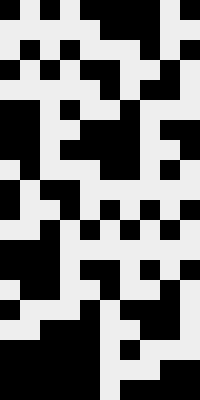

In [18]:
automaton_quilt(automaton, 20)

That's it! You've created a one-dimensional quantum cellular automaton, specified an update circuit, and visualised the output of successive runs. The rest of this document goes into how to control aspects of the automaton.

# Greater control

`pqca` comes with options that allow fine tuning of both the tessellation and the backend used by the automaton.

## Changing the tessellation

`pqca` supports partitions of a cuboid lattice of any given dimensions into cuboid cells of any given size (provided those cells fill the larger space when tessellated).

In [19]:
pqca.tessellation.n_dimensional([4,6,5],[2,3,5])

That's a tessellation of a lattice of shape $4 \times 6 \times 5$ into cells of shape $2 \times 3 \times 5$. The shape of the cell must divide the lattice. For cells of dimension higher than 1 the qubits are considered as being in lexicographic order when it comes to applying the update circuit.

In [20]:
pqca.tessellation.n_dimensional([2,2,2],[1,2,2]).cells

[[0, 1, 2, 3], [4, 5, 6, 7]]

Under the hood a tessellation is just a collection of cells where each qubit is used exactly once, and all the cells are the same size.

In [21]:
pqca.tessellation.Tessellation([[1,3],[0,2]]).cells

[[1, 3], [0, 2]]

You can still use the `shifted_by` method to shift a tessellation around by a number of qubits, but there is a more general `update_names` method you can use if you want greater control.

In [22]:
pqca.tessellation.Tessellation([[1,3],[0,2]]).update_names(lambda x: x+2).cells

[[3, 1], [2, 0]]

## Changing the backend

The default is to use qiskit's Aer simulator ([here is the API](https://qiskit.org/documentation/apidoc/aer.html?highlight=aer#)). Really a backend is a function that takes a combined preparation and update circuit, runs it, and returns a new state. `pqca.backend.qiskit` allows you to pass an optional qiskit backend, defaulting to `qasm_simulator`.

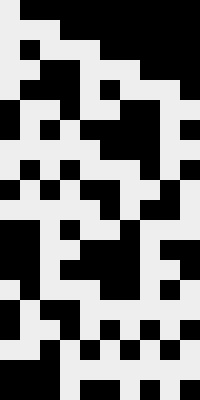

In [23]:
backend = pqca.backend.qiskit(qiskit.Aer.get_backend('statevector_simulator'))
automaton = pqca.Automaton(initial_state, [update_frame1, update_frame2], backend)
automaton_quilt(automaton, 20)

As you can see any function that takes a circuit and returns a state will do:

In [24]:
import random

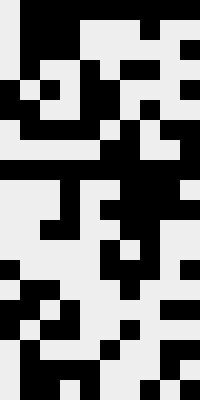

In [25]:
def classical_random_backend(circuit):
    return [random.choice([0,1]) for i in range(0,10)]
automaton = pqca.Automaton(initial_state, [update_frame1, update_frame2], classical_random_backend)
automaton_quilt(automaton, 20)

If you have access to a quantum computer then you can write a function that sends the circuit off and waits for the response.
For example if you are registered with IBM you can simply pass `provider.backend.[quantum computer name]` to `pqca.backend.qiskit` to get a backend suitable for these automata.

If writing your own backend remember that __a backend is simply a function from circuits to lists of ints__.

Thank you for reading this tutorial. For a practical application please check out the tutorial on synthesising music from a partitioned quantum cellular automaton, called `pqca_to_midi`.

Detailed documentation can be found at [readthedocs.io](https://partitioned-quantum-cellular-automata.readthedocs.io/en/latest/) as well as in the docstrings of the python files themselves. The pqca module and these tutorials are available under the MIT licence, with source code available at [Hector Miller-Bakewell’s github](https://github.com/hmillerbakewell/partitioned-quantum-cellular-automata). This package was created as part of the [QuTune Project](https://iccmr-quantum.github.io/).